In [1]:
# Importing libraries
import random
import os

import numpy as np
import pandas as pd

# TensorFlow Keras Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, 
                                     Flatten, Dense, Activation, BatchNormalization)

# SKLearn Library
from sklearn.model_selection import train_test_split

# Matplotlib for Plotting the Model
import matplotlib.pyplot as plt

In [58]:
# Define image properties
image_width = 128
image_height = 128
image_size = (image_width, image_height)
image_channels = 3

In [46]:
# Prepare Dataset for training model
filenames = os.listdir("./dataset/dogs-vs-cats/train")

categories = []
for f_name in filenames:
    category = f_name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})

test_filenames = os.listdir("./dataset/dogs-vs-cats/test1")

test_categories = []
for tf_name in test_filenames:
    category = tf_name.split('.')[0]
    if category == 'dog':
        test_categories.append(1)
    else:
        test_categories.append(0)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})
nb_samples = test_df.shape[0]

In [4]:
# Create Neural Network for Classifier Model
classifier = Sequential([
    # First Layer (Input Layer)
    Conv2D(32, (3,3), activation='relu', input_shape=(image_width, image_height, image_channels)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    # Neural Network Layers
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Flatten(), # Flatten the result
    Dense(512, activation='relu'), # Hidden Layer (512 Neuron)
    BatchNormalization(),
    Dropout(0.5), # Improve efficiency of a neural network
    Dense(2, activation='softmax'), # Last Layer (Output Layer)
])

In [5]:
# Compile the classifier model
classifier.compile(
    optimizer = RMSprop(),
    loss = CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [6]:
# Model Summary
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [7]:
# Define Callbacks and Learning Rate
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)
callbacks = [earlystop, learning_rate_reduction]

In [53]:
# Manage data
df['category'] = df['category'].replace({0: 'cat', 1:'dog'})
train_df, validate_df = train_test_split(
    df,
    test_size = 0.2,
    random_state = 42
)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

# Test_df preparation
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [48]:
# Create Train, Validation, and Test Datagen
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

validation_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

# Create Train, Validation and Test Dataset
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./dataset/dogs-vs-cats/train/",
    x_col='filename',
    y_col='category',
    target_size = image_size,
    class_mode = 'categorical',
    batch_size = batch_size
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dataset/dogs-vs-cats/train/", 
    x_col = 'filename',
    y_col = 'category',
    target_size = image_size,
    class_mode = 'categorical',
    batch_size = batch_size
)

test_generator = train_datagen.flow_from_dataframe(
    test_df,
    "./dataset/dogs-vs-cats/test1/",
    x_col = 'filename',
    y_col = 'category',                      
    target_size = image_size,                    
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames belonging to 1 classes.


In [10]:
# Train the Classifier Model
epochs = 10
history = classifier.fit(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

Epoch 1/10
1333/1333 [==============================] - 784s 587ms/step - loss: 0.9449 - accuracy: 0.5998 - val_loss: 0.5745 - val_accuracy: 0.7087
Epoch 2/10
1333/1333 [==============================] - 783s 588ms/step - loss: 0.5687 - accuracy: 0.7125 - val_loss: 0.7553 - val_accuracy: 0.6759
Epoch 3/10
1333/1333 [==============================] - 792s 594ms/step - loss: 0.5045 - accuracy: 0.7623 - val_loss: 0.4824 - val_accuracy: 0.7682
Epoch 4/10
1333/1333 [==============================] - 838s 628ms/step - loss: 0.4561 - accuracy: 0.7880 - val_loss: 0.4783 - val_accuracy: 0.8106
Epoch 5/10
1333/1333 [==============================] - 752s 564ms/step - loss: 0.4382 - accuracy: 0.8022 - val_loss: 0.9909 - val_accuracy: 0.6466
Epoch 6/10
1333/1333 [==============================] - 753s 565ms/step - loss: 0.4282 - accuracy: 0.8061 - val_loss: 0.6320 - val_accuracy: 0.7562

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/10
1333/1333 [=========

In [54]:
classifier.save("classifier1_cat&dog_10epochs.h5")

In [55]:
predict = classifier.predict(
    test_generator, 
    steps = np.ceil(nb_samples/batch_size)
)

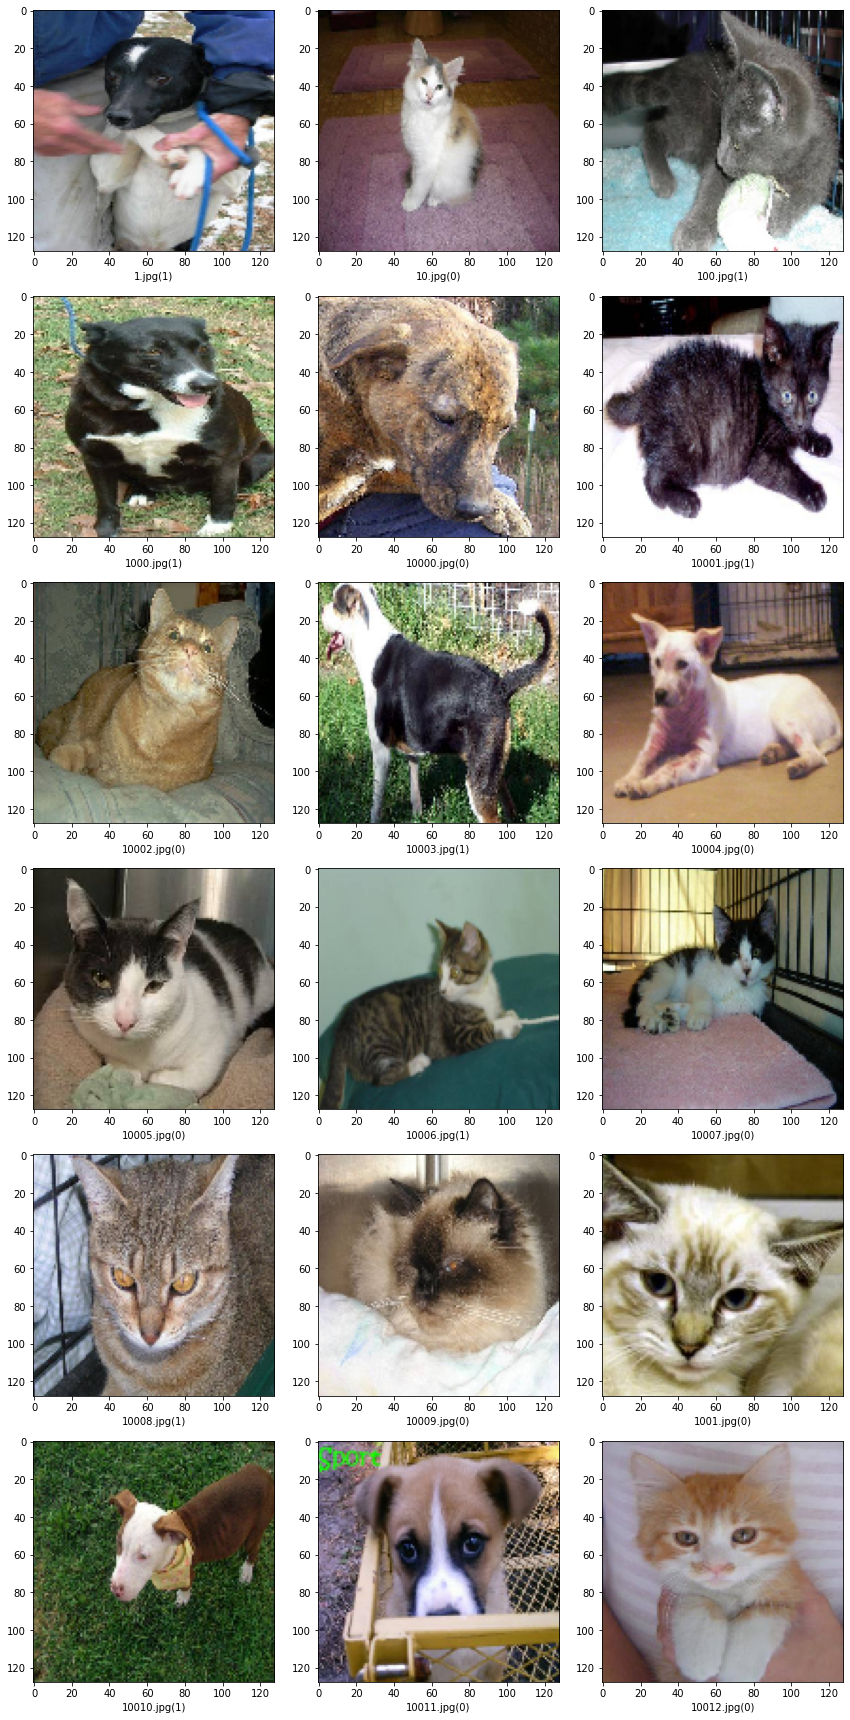

In [60]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./dataset/dogs-vs-cats/test1/"+filename, target_size=image_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [74]:
# Test Classifier Model performance on custom data
results = {
    0:'cat',
    1:'dog'
}

from PIL import Image

im = Image.open("./dataset/prediction/cat1.jpg")
im = im.resize(image_size)
im = np.expand_dims(im,axis=0)
im = np.array(im)
im = im/255
pred = classifier.predict_classes([im])[0]
print(pred,results[pred])

0 cat
